In [4]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

movies = pd.read_csv("D:/Recommender/input/movies.csv")
ratings = pd.read_csv("D:/Recommender/input/ratings.csv")

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


# Running Data Analysis:

1. Plot the counts of each rating
2. Plot rating frequency of each movie

<b>Plotting count of each rating</b>

In [10]:
# getting count of ratings
ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
#The dataframe does not have 0 as a rating, thus this code inserts 0 rating for unrated movies
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
ratings_cnt = ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


As we can see, the number of unrated or 0 ratings is much higher compared to the rest of ratings combined.
<br>
For visualization, we can use log graph to compare these numbers.

Text(0, 0.5, 'number of ratings')

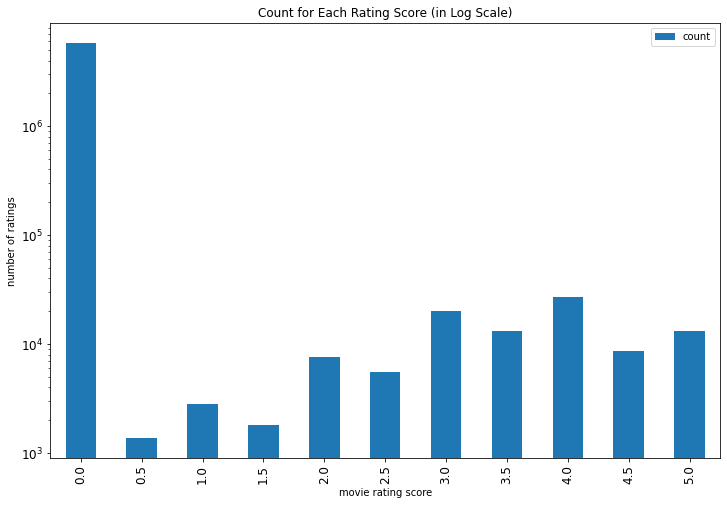

In [11]:
ax = ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

<b>Plotting rating frequency of each movie</b>

Text(0, 0.5, 'number of ratings')

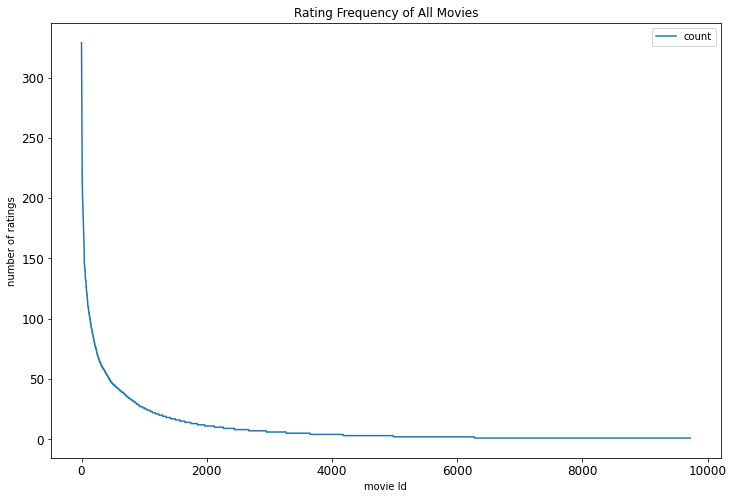

In [12]:
movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
# plot rating frequency of all movies
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

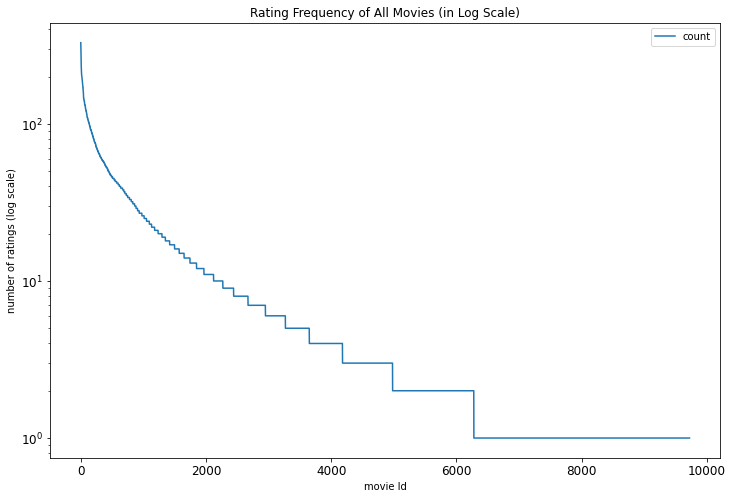

In [13]:
# plot rating frequency of all movies in log scale
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [15]:
movies_cnt['count'].quantile(np.arange(1, 0.3, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
0.60      4.0
0.55      3.0
0.50      3.0
0.45      2.0
0.40      2.0
0.35      1.0
Name: count, dtype: float64

From the given data, we can see that the top 1% of movies have more than 300 ratings, but as we move to the top 20%, the number reduces to almost 10. This is often referred to as the long-tail property, where the distribution is skewed as the vast majority of items are not frequently rated.

The given dataset of 10000 movies has a sizable proportion of movies with very few ratings, which would impact the KNN algorithm we wish to train. Thus, we can reduce the dataset size by restricting the no. of movies to the top 25% with more than 10 ratings, or around 2500 which is still a good dataset for training our algorithm. These reductions become even more neccessary for larger and sparser datasets.

In [36]:
# filter data
popularity_thres = 10
popular_movies = list(set(movies_cnt.query('count >= @popularity_thres').index))
ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', ratings_drop_movies.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping unpopular movies:  (81116, 4)


Next, we will have a look at the no. of users.

Text(0, 0.5, 'number of ratings')

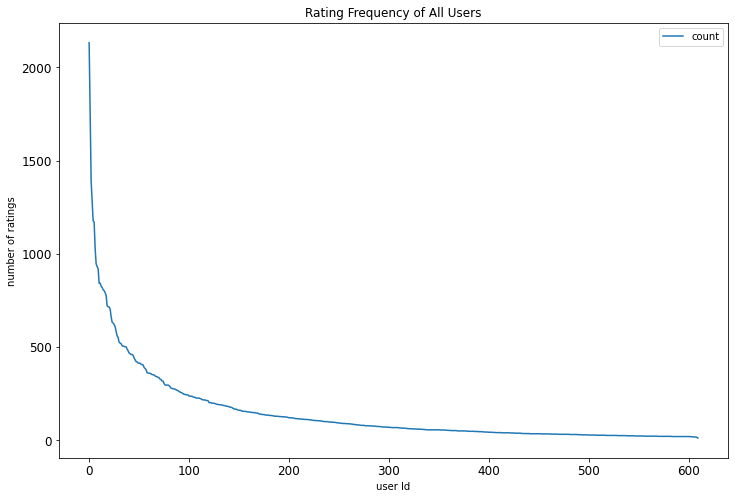

In [20]:
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('userId').size(), columns=['count'])
# plot rating frequency of all movies
ax = users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [21]:
users_cnt['count'].quantile(np.arange(1, 0.3, -0.05))

1.00    2132.00
0.95     523.75
0.90     359.00
0.85     257.60
0.80     201.20
0.75     159.00
0.70     132.30
0.65     113.00
0.60      97.00
0.55      80.00
0.50      68.00
0.45      58.00
0.40      52.00
0.35      44.15
Name: count, dtype: float64

The movie distribution graph does not have a very long tail, though the rating frequency is still quite high for a small fraction of viewers. We can thus limit the no. of users to the top 60%, who have rated more than 50 movies.

In [37]:
# filter data
ratings_thres = 50
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', ratings_drop_users.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (74371, 4)


# Train KNN model for item-based collaborative filtering
1. Reshaping the Data
2. Fitting the Model

<b>Reshaping the data</b>

For K-Nearest Neighbors, the data should be in an (artist, user) array, where each row is a movie and each column is a different user. To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. Any missing values can be imputed by 0.

In [38]:
final_dataset = ratings_drop_users.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,4.5,NaN,NaN,2.5,NaN,4.5,3.5,...,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN
3,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
5,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,4.0,...,NaN,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,5.0


In [56]:
final_dataset.fillna(0,inplace=True)
final_dataset = final_dataset.reset_index()
final_dataset

userId,level_0,index,movieId,1,4,6,7,10,11,15,...,600,601,602,603,604,605,606,607,608,610
0,0,0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,1,1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,2,2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,3,3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,4,4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264,2264,2264,174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2265,2265,2265,176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2266,2266,2266,177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2267,2267,2267,179819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our final_dataset has dimensions of 2269 * 378 where most of the values are sparse. For an indication, we shall calculate the sparsity of this dataset.

In [40]:
sparsity = 1.0 - ( np.count_nonzero(final_dataset) / float(final_dataset.size) )
print(sparsity)

0.9132883749454926


In order to reduce the sparsity of the matrix, we can use csr_matrix scipy lib, which is compatible with sklearn.

In [41]:
csr_data = csr_matrix(final_dataset.values)
print(csr_data)

  (0, 0)	4.0
  (0, 3)	4.5
  (0, 6)	2.5
  (0, 8)	4.5
  (0, 9)	3.5
  (0, 10)	4.0
  (0, 12)	3.5
  (0, 16)	3.0
  (0, 19)	3.0
  (0, 20)	3.0
  (0, 25)	5.0
  (0, 28)	5.0
  (0, 29)	4.0
  (0, 31)	3.0
  (0, 34)	5.0
  (0, 38)	5.0
  (0, 39)	4.0
  (0, 40)	4.0
  (0, 41)	2.5
  (0, 43)	4.5
  (0, 46)	0.5
  (0, 47)	4.0
  (0, 50)	2.5
  (0, 53)	4.0
  (0, 55)	3.0
  :	:
  (2266, 187)	4.0
  (2266, 205)	4.0
  (2266, 345)	1.5
  (2266, 357)	4.0
  (2266, 369)	4.5
  (2267, 37)	3.5
  (2267, 61)	3.0
  (2267, 97)	0.5
  (2267, 127)	4.5
  (2267, 156)	4.5
  (2267, 235)	0.5
  (2267, 255)	4.5
  (2267, 317)	2.0
  (2267, 345)	2.0
  (2267, 357)	5.0
  (2267, 365)	3.5
  (2268, 37)	4.0
  (2268, 61)	5.0
  (2268, 146)	2.5
  (2268, 156)	5.0
  (2268, 186)	5.0
  (2268, 205)	4.0
  (2268, 235)	3.0
  (2268, 317)	3.5
  (2268, 357)	4.0


We'll now fit the knn model to our sparse matrix in csr format. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

Using Euclidean distance is impractical, as most artist vectors have values of 0, and Pearson coefficient is much slower as comapred to cosine similarity, which we have used here.

In [42]:
# define model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [57]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [58]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Inception (2010),0.365006
2,Up (2009),0.364686
3,Guardians of the Galaxy (2014),0.364586
4,Watchmen (2009),0.364385
5,Star Trek (2009),0.361840
6,Avatar (2009),0.306339
7,Iron Man 2 (2010),0.302915
8,WALL·E (2008),0.302224
9,"Dark Knight, The (2008)",0.288273
10,"Avengers, The (2012)",0.280596


In [59]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Inception (2010),0.365006
2,Up (2009),0.364686
3,Guardians of the Galaxy (2014),0.364586
4,Watchmen (2009),0.364385
5,Star Trek (2009),0.361840
6,Avatar (2009),0.306339
7,Iron Man 2 (2010),0.302915
8,WALL·E (2008),0.302224
9,"Dark Knight, The (2008)",0.288273
10,"Avengers, The (2012)",0.280596


Our recommender system works perfectly for the given dataset. However, sparsity issues still persist in the knn algorithm which can be fixed by ALS.